# Exercício 10

In [1]:
import os
import numpy as np
import tensorflow.python.util.deprecation as deprecation
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from datetime import datetime

In [2]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.disable_v2_behavior()
tf.compat.v1.disable_resource_variables()

In [3]:
# Define the number of examples.
N = 1000

# Create the dataset.
X, y = make_moons(N, noise=0.1, random_state=42)

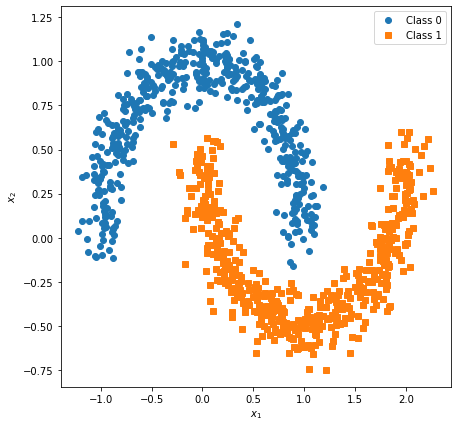

In [4]:
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

fig = plt.figure(figsize=(7,7))
plt.plot(X[idx0,0], X[idx0,1], 'o', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 's', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.savefig('distribution_of_classes_for_train_set', dpi=600)
plt.show()

In [5]:
y_vector = y.reshape(-1, 1)

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(X, y_vector, test_size=0.20, random_state=42)

print(f"Train data size is {x_train.shape}, train data label size is {y_train.shape}")
print(f"Test data size is {x_test.shape}, test data label size is {y_test.shape}")

Train data size is (800, 2), train data label size is (800, 1)
Test data size is (200, 2), test data label size is (200, 1)


In [6]:
x_train_h = np.c_[np.ones((len(y_train), 1)), x_train, x_train**2, x_train**3]
x_test_h = np.c_[np.ones((len(y_test), 1)), x_test, x_test**2, x_test**3]

print(f"Train data size is {x_train_h.shape}, train data label size is {y_train.shape}")
print(f"Test data size is {x_test_h.shape}, test data label size is {y_test.shape}")

Train data size is (800, 7), train data label size is (800, 1)
Test data size is (200, 7), test data label size is (200, 1)


In [7]:
def select_random_batch(X, y): 
    #Take Training data and Batch size as input
    random_index = np.random.randint(N)
    X_i = X[random_index:random_index+1]
    y_i = y[random_index:random_index+1]
    return X_i, y_i

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [8]:
reset_graph()

In [9]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs2"
logdir = "{}/run-{}/".format(root_logdir, now)

# Number of features
input_no =6 

# Placeholders
X = tf.placeholder(tf.float32, shape =(None, input_no + 1), name = "X" ) #Place holder for training data X
y = tf.placeholder(tf.float32, shape =(None, 1), name = "y" ) #Place holder for training label data y
theta = tf.Variable(tf.random_uniform([input_no + 1, 1], -1.0, 1.0, seed=42), name="theta") #Initialize the Random value for theta
y_pred = tf.matmul(X, theta, name="predictions")

# Operations
logits = tf.matmul(X, theta, name="logits") #Tensorflow operations
y_proba = tf.sigmoid(logits) #Calculate the probability
loss = tf.losses.log_loss(y, y_proba) #Loss function

learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

epochs = 2000

train_summary = tf.summary.scalar('Training', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        for idx in range(N):
            X_i, y_i = select_random_batch(x_train_h, y_train)
            sess.run(training_op, feed_dict={X: X_i, y: y_i})
            loss_val = loss.eval({X: x_test_h, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            y_proba_val = y_proba.eval(feed_dict={X: x_test_h, y: y_test})
                                    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")                           

file_writer.close()  

Epoch: 0 	Loss: 0.36365438
Epoch: 100 	Loss: 0.04620349
Epoch: 200 	Loss: 0.0303091
Epoch: 300 	Loss: 0.023701778
Epoch: 400 	Loss: 0.019765927
Epoch: 500 	Loss: 0.017867256
Epoch: 600 	Loss: 0.01638909
Epoch: 700 	Loss: 0.014622293
Epoch: 800 	Loss: 0.013669419
Epoch: 900 	Loss: 0.012458577
Epoch: 1000 	Loss: 0.012169467
Epoch: 1100 	Loss: 0.01124984
Epoch: 1200 	Loss: 0.010501978
Epoch: 1300 	Loss: 0.010323923
Epoch: 1400 	Loss: 0.009708179
Epoch: 1500 	Loss: 0.009519891
Epoch: 1600 	Loss: 0.009150004
Epoch: 1700 	Loss: 0.0089271255
Epoch: 1800 	Loss: 0.008491191
Epoch: 1900 	Loss: 0.008338716


In [10]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()
    
np.allclose(best_theta, best_theta_restored)

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


True

In [11]:
y_pred = (y_proba_val >= 0.5)

In [12]:
precision_score(y_test, y_pred)

1.0

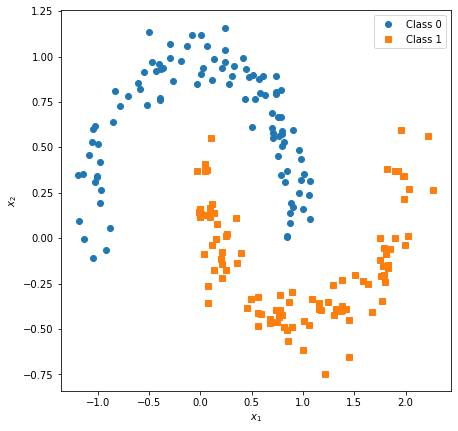

In [13]:
y_pred_idx = y_pred.reshape(-1) 

idx0 = np.argwhere(y_pred_idx == 0)
idx1 = np.argwhere(y_pred_idx == 1)

fig = plt.figure(figsize=(7,7))
plt.plot(x_test[idx0,0], x_test[idx0,1], 'o', label='Class 0')
plt.plot(x_test[idx1,0], x_test[idx1,1], 's', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.savefig('distribution_of_classes_for_train_set', dpi=600)
plt.show()